# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:19<00:00, 3.15KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

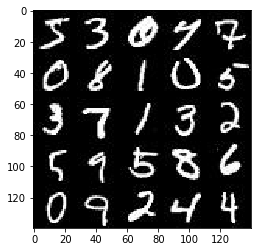

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

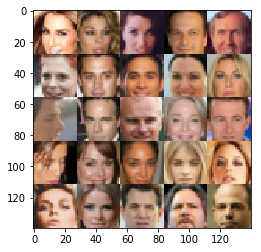

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [154]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_inputs = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32, None)

    return real_inputs, z_inputs, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instanc

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [155]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    '''
    hidden_units_1 = 128
    hidden_units_2 = 64
    hidden_units_3 = 32
    '''
    alpha = 0.2
        
    with tf.variable_scope('discriminator', reuse=reuse):
        '''
        shape = images.get_shape().as_list()
        
        images = tf.reshape(images, [-1, shape[1] * shape[2] * shape[3]])
        
        hidden = tf.layers.dense(images, hidden_units_1, activation=None)
        hidden = tf.maximum(alpha * hidden, hidden)
        
        hidden = tf.layers.dense(hidden, hidden_units_2, activation=None)
        hidden = tf.maximum(alpha * hidden, hidden)
        
        hidden = tf.layers.dense(hidden, hidden_units_3, activation=None)
        hidden = tf.maximum(alpha * hidden, hidden)
        
        logits = tf.layers.dense(hidden, 1, activation=None)
        output = tf.sigmoid(logits)
        '''
        
        conv = tf.layers.conv2d(images, 64, 5, 2, 'same')
        conv = tf.maximum(alpha * conv, conv)
        
        conv = tf.layers.conv2d(conv, 128, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        
        conv = tf.layers.conv2d(conv, 256, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        
        logits = tf.layers.dense(tf.reshape(conv, [-1, 4 * 4 * 256]), 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [159]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    '''
    hidden_units_1 = 128
    hidden_units_2 = 64
    hidden_units_3 = 32
    '''
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        '''
        hidden = tf.layers.dense(z, hidden_units_1, activation=None)
        hidden = tf.maximum(alpha * hidden, hidden)
        
        hidden = tf.layers.dense(hidden, hidden_units_2, activation=None)
        hidden = tf.maximum(alpha * hidden, hidden)
        
        hidden = tf.layers.dense(hidden, hidden_units_3, activation=None)
        hidden = tf.maximum(alpha * hidden, hidden)
        
        logits = tf.layers.dense(hidden, 28 * 28 * out_channel_dim, activation=None)
        output = tf.tanh(logits)
        
        output = tf.reshape(output, [-1, 28, 28, out_channel_dim])
        '''
        
        conv = tf.layers.dense(z, 2 * 2 * 512)
        conv = tf.reshape(conv, [-1, 2, 2, 512])
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
    
        conv = tf.layers.conv2d_transpose(conv, 256, 5, 2, 'valid')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
    
        conv = tf.layers.conv2d_transpose(conv, 128, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
    
        logits = tf.layers.conv2d_transpose(conv, out_channel_dim, 5, 2, 'same')
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [160]:
tf.reset_default_graph()


def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_out = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_real_labels = tf.ones_like(d_model_real)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_labels))
    
    d_fake_labels = tf.zeros_like(d_model_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_labels))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_labels = tf.ones_like(d_model_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [161]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [175]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, learn_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batches = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batches += 1
                
                batch_images *= 2.0
                
                z_batches = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_batches, learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={z_input: z_batches, learn_rate: learning_rate})
                
                if batches % 100 == 0:
                    show_generator_output(sess, 9, z_input, img_channels, data_image_mode)
                    
                if batches % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: z_batches, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batches})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 17.0845
Epoch 1/2... Discriminator Loss: 8.0808... Generator Loss: 0.0004
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 4.4492
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 6.1120
Epoch 1/2... Discriminator Loss: 1.9934... Generator Loss: 0.3823
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 2.0439
Epoch 1/2... Discriminator Loss: 0.7612... Generator Loss: 11.3369
Epoch 1/2... Discriminator Loss: 1.8578... Generator Loss: 10.3904
Epoch 1/2... Discriminator Loss: 0.3003... Generator Loss: 1.9671


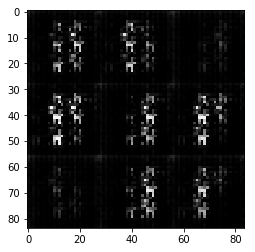

Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 1.7003
Epoch 1/2... Discriminator Loss: 0.1608... Generator Loss: 3.2485
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 2.5742
Epoch 1/2... Discriminator Loss: 2.0436... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 0.3223... Generator Loss: 2.3259
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 1.7078
Epoch 1/2... Discriminator Loss: 0.1940... Generator Loss: 2.3328
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 8.9262
Epoch 1/2... Discriminator Loss: 0.2876... Generator Loss: 2.7405


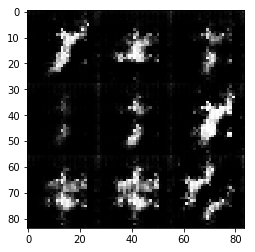

Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 7.6292
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 5.5743
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 0.4806... Generator Loss: 2.5384
Epoch 1/2... Discriminator Loss: 0.4986... Generator Loss: 1.8647
Epoch 1/2... Discriminator Loss: 0.2881... Generator Loss: 4.1692
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 0.1410... Generator Loss: 3.0792
Epoch 1/2... Discriminator Loss: 0.3961... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 0.7402... Generator Loss: 1.5907


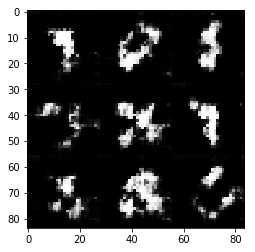

Epoch 1/2... Discriminator Loss: 0.4132... Generator Loss: 3.1845
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.6125
Epoch 1/2... Discriminator Loss: 0.5853... Generator Loss: 2.0569
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 2.3064
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 3.0367
Epoch 1/2... Discriminator Loss: 0.5618... Generator Loss: 2.6224
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 1.4935
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 2.4915
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.3704


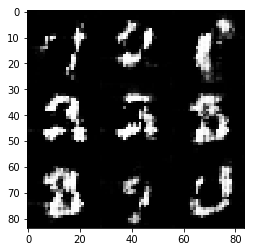

Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 1.6242
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 1.8978
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.5821
Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 1.7240
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 1.5619
Epoch 1/2... Discriminator Loss: 0.7149... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 2.8480


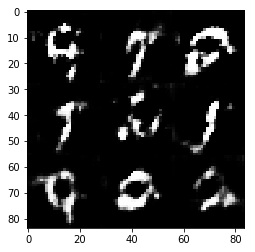

Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 4.9728
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 2.6934
Epoch 1/2... Discriminator Loss: 0.5056... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 3.9531
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 1.5494
Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 1.7578
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 2.2943
Epoch 1/2... Discriminator Loss: 0.8524... Generator Loss: 1.1617
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.6381


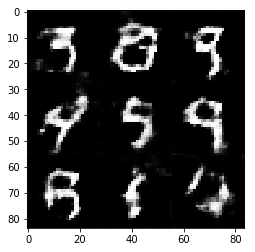

Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.6355
Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 0.6709... Generator Loss: 1.5673
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 2.2512
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 2.1318
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.5347
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 0.5196... Generator Loss: 2.1535


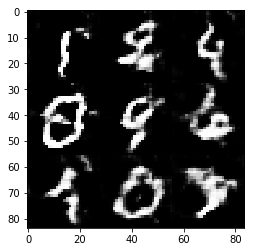

Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.8617
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 1.2536
Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 2.8456
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 1.9183
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 2.0302
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 0.6728... Generator Loss: 1.9156


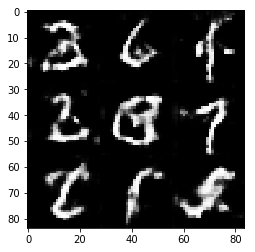

Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 0.6431... Generator Loss: 1.7959
Epoch 1/2... Discriminator Loss: 0.4920... Generator Loss: 1.6651
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 2.0247
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.8376


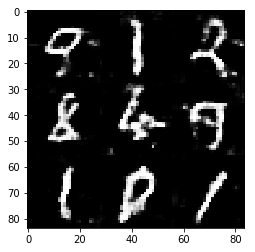

Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 2.0308
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 1.1991
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.5369
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.1842
Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 1.9264
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.5154


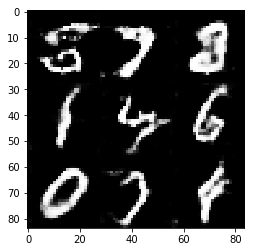

Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 0.6176... Generator Loss: 1.5828
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 1.9246
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.2386
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.7028
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 0.8605
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.6852


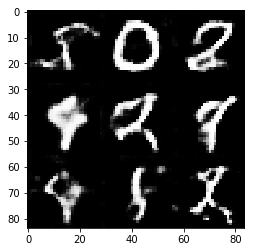

Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.8407
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.1795
Epoch 2/2... Discriminator Loss: 1.8430... Generator Loss: 0.2880
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.1034


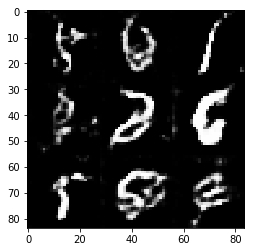

Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 1.7408
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.1045
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.7078


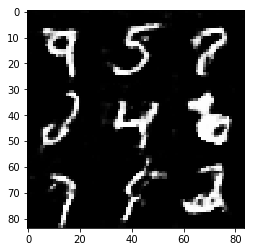

Epoch 2/2... Discriminator Loss: 0.7418... Generator Loss: 2.2016
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.6536
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 2.8074... Generator Loss: 0.0993
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.6167
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 1.4483
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.0272


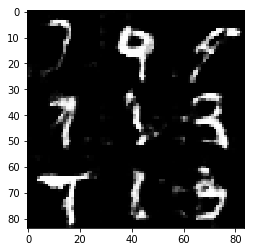

Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.5240
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 1.3296
Epoch 2/2... Discriminator Loss: 2.9251... Generator Loss: 0.1159
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.5159
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 1.6765
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.5638
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.4799


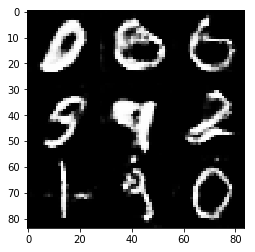

Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 1.5726... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 1.2028
Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.1502
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.6063... Generator Loss: 4.0089
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 0.9439


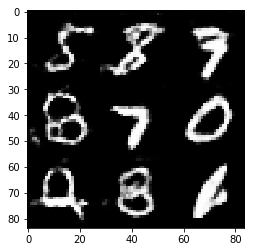

Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 1.7852
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.4174
Epoch 2/2... Discriminator Loss: 0.5920... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 0.6658... Generator Loss: 1.9825
Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 0.9557


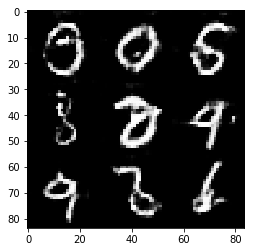

Epoch 2/2... Discriminator Loss: 1.8713... Generator Loss: 0.2685
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.7995... Generator Loss: 0.3025
Epoch 2/2... Discriminator Loss: 0.7697... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.7485
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.0760


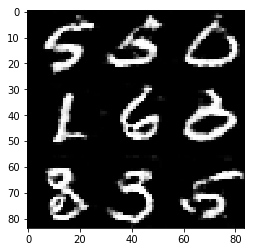

Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 0.9763
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.1873
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 1.2826
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.6557
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.4622


In [176]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 2.4792... Generator Loss: 0.1067
Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 3.5931
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 19.0080
Epoch 1/1... Discriminator Loss: 0.3040... Generator Loss: 8.8770
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 3.7600... Generator Loss: 12.0308
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5211


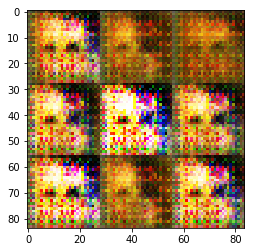

Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 7.0114
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.8780
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 2.2136
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 2.7155


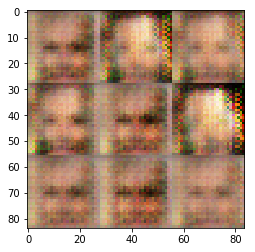

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.5757
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 2.7774
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 3.3864
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 1.7947
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 1.8001


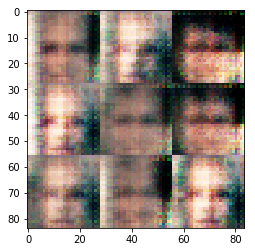

Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 2.0560
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 2.0649... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.3634


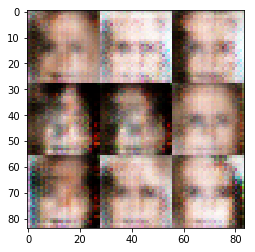

Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 3.2964
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.8023... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 2.0570
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.7160... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.5876


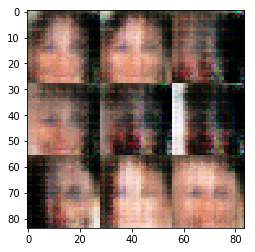

Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 3.5207
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 2.7251
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 3.5581
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.5764


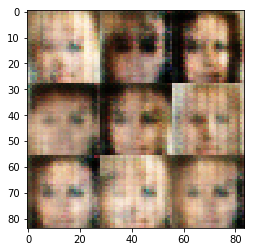

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 2.3764
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 2.5711
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.5765
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 2.7758
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.8203
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.8853


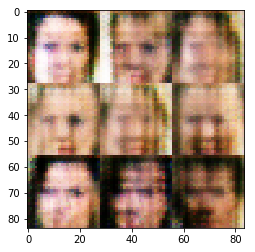

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 2.6771
Epoch 1/1... Discriminator Loss: 1.9208... Generator Loss: 4.2175
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.9722
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.5285


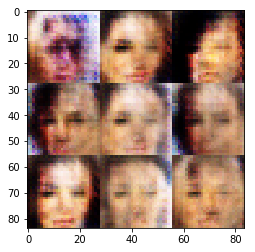

Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.7850
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 2.1921... Generator Loss: 0.1904


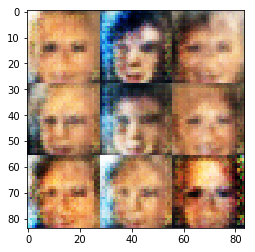

Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9574


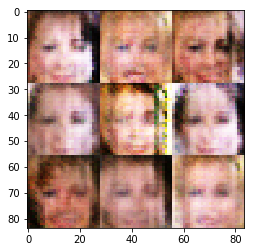

Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.4883


KeyboardInterrupt: 

In [179]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.